# Linear predictions on the MNIST dataset

MNIST Dataset contains 60000 images of hand drawn digits. We will train a linear model to classify the images

Downloading the dataset

In [38]:
from tensorflow.examples.tutorials.mnist import input_data
data=input_data.read_data_sets("data/MNIST/",one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [40]:
print("Size of training set:\t ",len(data.train.labels))
print("Size of test set:\t ",len(data.test.labels))
print("Size of validation set:\t ",len(data.validation.labels))

Size of training set:	  55000
Size of test set:	  10000
Size of validation set:	  5000


In [41]:
data.test.labels[0]
#The labels are one hot encoded, meaning the array below stands for 7

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [42]:
#For performance measures, making a new array with actual numbers from the one hot encoded values
data.test.cls=np.array([label.argmax() for label in data.test.labels])
data.test.cls[:5]

array([7, 2, 1, 0, 4], dtype=int64)

In [43]:
#Declaring sizes and shapes for input shapes
#Images are 28x28
img_size=28
img_size_flat=28*28
img_shape=(img_size,img_size)
#There are 10 numbers
num_classes=10

In [44]:
#Helper function for plotting sample images

def img_plot(images,cls_true,cls_pred=None):
    #Check if image array of length nine was input
    assert len(images==9)
    fig,axes=plt.subplots(3,3)
    #Adjusting the plot
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    for i,axis in enumerate(axes.flat):
        #Show the image in correct size, black and white
        axis.imshow(images[i].reshape(img_shape),cmap='binary')
        
        if cls_pred is None:
            #If predicted classes were not passed as parameter
            xlabel="True: "+str(cls_true[i])
        else:
            xlabel="True: "+str(cls_true[i])+" Predicted: "+str(cls_pred[i])
        
        #Setting label and removing ticks from the plots
        axis.set_xlabel(xlabel)
        axis.set_xticks([])
        axis.set_yticks([])
    plt.show()

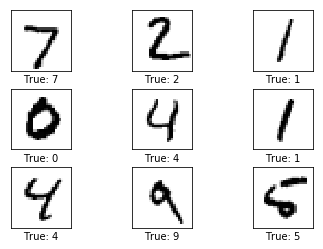

In [45]:
#Testing the img plot function

images=data.test.images[:9]
cls_true=data.test.cls[:9]
img_plot(images,cls_true)

Making the linear model using tensorflow placeholders and variables

In [46]:
#Placeholder for input image
x=tf.placeholder(tf.float32,[None,img_size_flat])
#Placeholder for true labels associated with images that were given as input
y_true=tf.placeholder(tf.float32,[None,num_classes])
#Placeholder for true class
y_true_cls=tf.placeholder(tf.int64,[None])

In [47]:
#Variables declaration
#These weights and biases are going to be optimized by our model
#We have the formula y=Wx+B where y is the output
#Optimal values of W and B will give us an accurate y
weights=tf.Variable(tf.zeros([img_size_flat,num_classes]))
biases=tf.Variable(tf.zeros([num_classes]))

In [48]:
#y=wx+b
logits=tf.matmul(x,weights)+biases

In [49]:
#Logits stores 10 values, the weights of the predicted number
y_pred=tf.nn.softmax(logits)
#Softmax function find e^yi/sum(e^yi)
#So basically we get probabilities of each image representing each digit
y_pred_cls=tf.argmax(y_pred,axis=1)
#Argmax finds the largest value in the softmax function, this is our prediction

In [50]:
#To see how well model is working and change values of weights and biases accordingly
#We use cross entropy. This is a measure that compares model predictions to y_true
cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_true)

In [51]:
#This is the difference of predicted values and real values
cost=tf.reduce_mean(cross_entropy)

In [52]:
#We use RMS optimizer with a learning rate of 0.5 to minimize the cost
optimizer=tf.train.RMSPropOptimizer(learning_rate=0.5).minimize(cost)

In [53]:
#Correct predictions are where predicted and true classes are equal
correct_prediction=tf.equal(y_pred_cls,y_true_cls)
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

Starting the tensorflow session

In [54]:
session=tf.Session()

In [55]:
#Initialize all variables
session.run(tf.global_variables_initializer())

In [56]:
#Train these many images at the same time
batch_size=200

In [57]:
#Main function that optimizes the model
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch,y_true_batch=data.train.next_batch(batch_size)
        #Put the batch into a dictionary for the placeholders x and y_true
        feed_dict_train={x:x_batch,y_true:y_true_batch}
        session.run(optimizer,feed_dict=feed_dict_train)

In [58]:
#Test dictionary
feed_dict_test={x:data.test.images,y_true:data.test.labels,y_true_cls:data.test.cls}

In [59]:
#Function to print accuracy of the model
def print_accuracy():
    acc=session.run(accuracy,feed_dict=feed_dict_test)
    print("Accuracy on test-set is : ",acc*100)

In [60]:
#Prints the confusion matrix, where we can see predicted values
def print_confusion_matrix():
    #Get true classifications for the test set
    cls_true=data.test.cls
    #Get predicted classifications for the test set
    cls_pred=session.run(y_pred_cls,feed_dict=feed_dict_test)
    
    #Get confusion matrix using sklearn
    #Pass true and predicted values to the function
    cm=confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    
    #This prints the confusion matrix as text
    print(cm)
    
    #This prints it as a plot
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    
    #Make small visual changes to the plot
    
    plt.tight_layout()
    plt.colorbar()
    tick_marks=np.arange(num_classes)
    plt.xticks(tick_marks,range(num_classes))
    plt.yticks(tick_marks,range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    
    plt.show()

In [61]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    img_plot(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [62]:
#Without training, all are predicted as 0, so accuracy is 9.8% (9.8% of all images are 0)
print_accuracy()

Accuracy on test-set is :  9.799999743700027


In [63]:
#Run the optimize function for one iteration
optimize(num_iterations=1)
print_accuracy()
#20% accuracy after one iteration

Accuracy on test-set is :  34.52000021934509


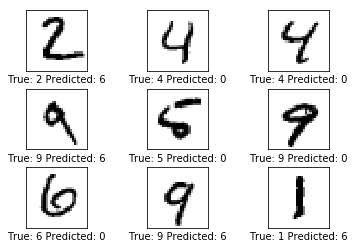

In [64]:
plot_example_errors()
#Model is pretty bad, so we train for more iterations

In [65]:
%%time
optimize(num_iterations=99)
#Total 100 iterations now
print_accuracy()

Accuracy on test-set is :  73.0400025844574
Wall time: 373 ms


In [66]:
optimize(num_iterations=900)
#Total 1000 iterations now
print_accuracy()

Accuracy on test-set is :  86.58999800682068


In [67]:
optimize(num_iterations=9000)
#10000 iterations total

In [68]:
print_accuracy()

Accuracy on test-set is :  90.57000279426575


[[ 944    0    1    2    1   14    9    1    7    1]
 [   0 1108    5    2    0    1    4    1   14    0]
 [   6   14  901   26    5    6   21    6   43    4]
 [   3    1   14  880    0   73    5    8   24    2]
 [   1    3    6    6  815    6   28    9   31   77]
 [   6    3    1   26    4  796   20    1   32    3]
 [   5    4    6    4    2   19  913    1    4    0]
 [   2   11   21   20    2    4    1  911   11   45]
 [   5    8    5   27    5   39   10    3  869    3]
 [   7    5    1   12    7   16    0   13   28  920]]


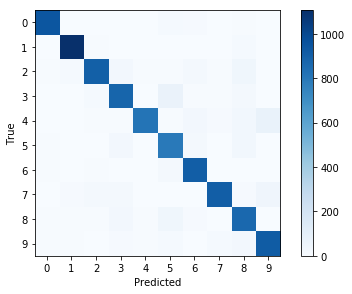

In [69]:
#We can see that 4 is often being predicted as 9 and 3 as 5, understandable
print_confusion_matrix()

In [70]:
session.close()

10000 iterations with RMSProp gives us 90.57% accuracy

Credit to Hvass Laboratories (https://www.youtube.com/user/hvasslabs)